In [ ]:
!pip install cvzone

  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.6.1-py3-none-any.whl size=26298 sha256=f3cf0738d1a9669880f191db3e1e20abd66a778b7124e25c647e100de8f56f7c
  Stored in directory: /root/.cache/pip/wheels/ab/36/ec/47be2d4e59dc4289e684d5b0dde54d1e72e51a614e57690e85
Successfully built cvzone


In [ ]:
!pip uninstall mediapipe cvzone -y
!pip install mediapipe cvzone --no-cache-dir

Found existing installation: mediapipe 0.10.21
Uninstalling mediapipe-0.10.21:
  Successfully uninstalled mediapipe-0.10.21
Found existing installation: cvzone 1.6.1
Uninstalling cvzone-1.6.1:
  Successfully uninstalled cvzone-1.6.1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 121.6 MB/s eta 0:00:00
  Created wheel for cvzone: filename=cvzone-1.6.1-py3-none-any.whl size=26298 sha256=781e24e4de7557d877fa6eaf97a3cdcb6da8dee7001b42839883cdd0caa86c6e
  Stored in directory: /tmp/pip-ephem-wheel-cache-zbfmglt1/wheels/ab/36/ec/47be2d4e59dc4289e684d5b0dde54d1e72e51a614e57690e85
Successfully built cvzone


In [ ]:
import cv2
from cvzone.HandTrackingModule import HandDetector

📸 Please run the code and show your hand to the camera.


<IPython.core.display.Javascript object>

 Detected Fingers , Thumb: 4,1


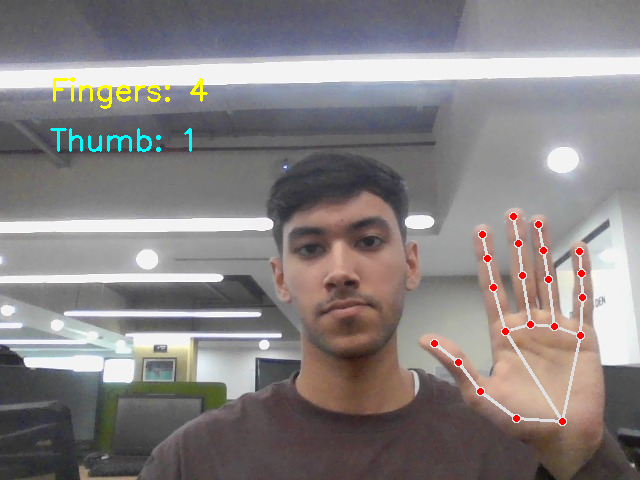

In [ ]:
from google.colab.output import eval_js
from IPython.display import display, Javascript
from cvzone.HandTrackingModule import HandDetector
import cv2
import numpy as np
import PIL.Image
import io
import base64
from google.colab.patches import cv2_imshow
import mediapipe as mp

mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)

js = Javascript('''
    async function captureImage() {
        const video = document.createElement('video');
        document.body.appendChild(video);
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await new Promise((resolve) => video.onloadedmetadata = resolve);
        video.play();

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);

        stream.getTracks().forEach(track => track.stop());
        video.remove();

        return canvas.toDataURL('image/jpeg');
    }
''')

def capture_frame():
    display(js)
    data = eval_js("captureImage()")
    _, encoded = data.split(',', 1)
    image_bytes = base64.b64decode(encoded)
    image = PIL.Image.open(io.BytesIO(image_bytes))
    return np.array(image)

def count_fingers(hand_landmarks):
    finger_tips = [8, 12, 16, 20]
    fingers_up = 0
    landmarks = hand_landmarks.landmark

    for tip in finger_tips:
        if landmarks[tip].y < landmarks[tip - 2].y:
            fingers_up += 1

    return fingers_up

def detect_thumb(hand_landmarks):
    landmarks = hand_landmarks.landmark
    if landmarks[4].y < landmarks[1].y:
        return 1
    return 0

print("📸 Please run the code and show your hand to the camera.")
frame = capture_frame()

frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

frame_resized = cv2.resize(frame, (640, 480))

results = hands.process(cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB))

if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        mp_draw.draw_landmarks(frame_resized, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        fingers_up = count_fingers(hand_landmarks)
        thumb_up = detect_thumb(hand_landmarks)

        cv2.putText(frame_resized, f'Fingers: {fingers_up}', (50, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        if thumb_up == 1:
            cv2.putText(frame_resized, 'Thumb: 1', (50, 150),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

    print(f" Detected Fingers , Thumb: {fingers_up},{thumb_up}")
else:
    print(" No hands detected. Try again.")

cv2_imshow(frame_resized)
